In [2]:
import math
import os
import re
from sklearn.model_selection import GridSearchCV
import numpy as np
from skimage.transform import resize
from skimage import img_as_float, io
from skimage.io import imread
from skimage.color import *
from skimage.restoration import denoise_tv_chambolle
from sklearn import svm, metrics
import joblib


confirmed_images_re = re.compile(r'([a-zA-Z0-9]{5})\.png$')

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

<ipython-input-31-a57ef41c2432>:2: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  img = img_as_float(rgb2gray(io.imread(path)))


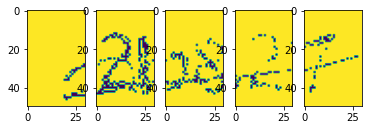

In [31]:
def load_image(path):
        img = img_as_float(rgb2gray(io.imread(path)))
        img[img != 0] = 1
        return img
def get_letters(img, number=5, avg_size=30):
    for i in range(number):
        start = i*avg_size
        nimg = img.copy()[:,start:start + avg_size]
        width_difference = avg_size - nimg.shape[1]
        if(width_difference != 0):
            nimg = np.append(nimg, np.ones((nimg.shape[0], width_difference)), axis = 1)
        yield nimg

not_trained_captcha = load_image('samples/2b827.png')
fig, ax = plt.subplots(ncols=5)

for i, letter in enumerate(get_letters(not_trained_captcha)):
    ax[i].imshow(letter)

In [32]:
data_path = fr'C:\Users\Stefan\aicourse\samples'
os.listdir(data_path)

['226md.png',
 '22d5n.png',
 '2356g.png',
 '23mdg.png',
 '23n88.png',
 '243mm.png',
 '244e2.png',
 '245y5.png',
 '24f6w.png',
 '24pew.png',
 '25257.png',
 '253dc.png',
 '25egp.png',
 '25m6p.png',
 '25p2m.png',
 '25w53.png',
 '264m5.png',
 '268g2.png',
 '28348.png',
 '28x47.png',
 '2b827.png',
 '2bg48.png',
 '2cegf.png',
 '2cg58.png',
 '2cgyx.png',
 '2en7g.png',
 '2enf4.png',
 '2fxgd.png',
 '2g783.png',
 '2g7nm.png',
 '2gyb6.png',
 '2mg87.png',
 '2mpnn.png',
 '2n73f.png',
 '2nbc5.jpg',
 '2nbcx.png',
 '2nf26.png',
 '2npg6.png',
 '2nx38.png',
 '2p2y8.png',
 '2pfpn.png',
 '2w4y7.png',
 '2wc38.png',
 '2wx73.png',
 '2x7bm.png',
 '2xc2n.png',
 '2ycn8.png',
 '2yggg.png',
 '325fb.png',
 '32cnn.png',
 '32dnn.png',
 '33b22.png',
 '33f7m.png',
 '33n73.png',
 '33ng4.png',
 '33p4e.png',
 '34b84.png',
 '34fxm.png',
 '34pcn.png',
 '368y5.png',
 '36bc2.png',
 '36nx4.png',
 '36w25.png',
 '373gb.png',
 '377xx.png',
 '378e5.png',
 '37d52.png',
 '37ep6.png',
 '387g2.png',
 '38n57.png',
 '3b4we.png',
 '3bd8

In [33]:
imgs = []
limit_images = 1070
total_to_train = int(limit_images * 0.8)
loaded_images = 0
for filename in os.listdir('samples'):
    match = confirmed_images_re.search(filename)
    if not match:
        continue
    try:
        imgs.append((match.group(1).lower(), load_image('samples/{}'.format(filename))))
    except (IndexError, OSError):
        continue
    loaded_images += 1
    if loaded_images == limit_images:
        break
print('{} images'.format(len(imgs)))
letters_image = []
letters_ascii = []
for image in imgs:
    letters, image = image
    for column, letter_image in enumerate(get_letters(image)):
        letters_image.append(letter_image.flatten())
        letters_ascii.append(letters[column])


<ipython-input-31-a57ef41c2432>:2: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  img = img_as_float(rgb2gray(io.imread(path)))


1040 images


In [34]:
model = svm.SVC(C=100, gamma=0.001, probability=False)
model.fit(letters_image[:total_to_train], letters_ascii[:total_to_train])

SVC(C=100, gamma=0.001)

In [35]:
predicted = model.predict(letters_image[total_to_train:])
expected = letters_ascii[total_to_train:]
print(metrics.classification_report(expected, predicted))

              precision    recall  f1-score   support

           2       0.21      0.58      0.31       178
           3       0.10      0.38      0.16       165
           4       0.22      0.42      0.29       200
           5       0.30      0.32      0.31       223
           6       0.33      0.11      0.16       227
           7       0.62      0.33      0.43       211
           8       0.27      0.22      0.24       227
           b       0.16      0.25      0.20       204
           c       0.24      0.09      0.13       234
           d       0.29      0.16      0.21       228
           e       0.39      0.19      0.26       207
           f       0.38      0.27      0.32       239
           g       0.32      0.30      0.31       234
           m       0.19      0.14      0.16       242
           n       0.28      0.38      0.32       459
           p       0.50      0.25      0.33       223
           w       0.27      0.21      0.24       204
           x       0.32    

In [36]:
def decode_captcha(filename, func=None):
    func = func or model.predict
    return func([l.flatten() for l in get_letters(load_image(filename))])

filename = 'samples/{}'.format(np.random.choice(os.listdir('samples')))
print(filename, ''.join(decode_captcha(filename, model.predict)))

samples/eppg3.png 2wnn4


<ipython-input-31-a57ef41c2432>:2: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  img = img_as_float(rgb2gray(io.imread(path)))


In [37]:
params = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                    'C': [1, 10, 100, 1000]},
                   {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
   
clf = GridSearchCV(svm.SVC(), params, n_jobs=1)
clf.fit(letters_image[:total_to_train], letters_ascii[:total_to_train])

GridSearchCV(estimator=SVC(), n_jobs=1,
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}])

In [38]:
print(clf.best_estimator_)
clf.cv_results_ 

SVC(C=100, gamma=0.001)


{'mean_fit_time': array([0.37997079, 0.36177573, 0.4035552 , 0.3650516 , 0.40994949,
        0.40035539, 0.41176262, 0.41213937, 0.38799372, 0.41875687,
        0.41218481, 0.41950541]),
 'std_fit_time': array([0.0178795 , 0.00399688, 0.00754993, 0.00695371, 0.00244599,
        0.00722906, 0.00561334, 0.00194087, 0.00521755, 0.02366871,
        0.03623616, 0.01544658]),
 'mean_score_time': array([0.14916239, 0.13610435, 0.13708787, 0.1393568 , 0.14022527,
        0.13854718, 0.14167051, 0.14191566, 0.0867744 , 0.13279905,
        0.09311624, 0.10461173]),
 'std_score_time': array([0.00750847, 0.00580365, 0.00609939, 0.00164001, 0.0027602 ,
        0.0070514 , 0.00185943, 0.00312582, 0.00598468, 0.04568846,
        0.0148998 , 0.02603715]),
 'param_C': masked_array(data=[1, 1, 10, 10, 100, 100, 1000, 1000, 1, 10, 100, 1000],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_value='?',
             dt